In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split


In [2]:
# MLFA Lab Test 2 
# Name: Vaibhav Gupta
# Roll Number: 20IE10041

# Experiment 1: Making implementation deterministic
import torch,torchvision
import random

seed_value = 2020  #Joining year
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

device = torch.device('cpu')

# Experiment 2: Data Preparation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# Load dataset
data_dir = "lab_test_2_dataset"
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

print(dataset)


Dataset ImageFolder
    Number of datapoints: 9778
    Root location: lab_test_2_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
# Shuffle and split dataset
train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=seed_value)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=seed_value)

# Define batch size
batch_size = 64

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Print dataset sizes
print("Overall dataset size:", len(dataset))
print("Training dataset size:", len(train_indices))
print("Validation dataset size:", len(val_indices))
print("Testing dataset size:", len(test_indices))



Overall dataset size: 9778
Training dataset size: 6844
Validation dataset size: 1467
Testing dataset size: 1467


In [5]:
# Experiment 3: CNN Regression Model
import torch.nn as nn
import torch.nn.functional as F

class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8*4, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         print(x.size())
        x = F.relu(self.conv2(x))
#         print(x.size())
        x = F.max_pool2d(x, 2)
#         print(x.size())
        x = x.view(-1, 32 * 8 * 8*4)
#         print(x.size())
        x = F.relu(self.fc1(x))
#         print(x.size())
        x = F.relu(self.fc2(x))
#         print(x.size())
        x = self.fc3(x)
#         print(x.size())
        return x


# Experiment 4: Training the Model
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize the model, criterion, and optimizer
model = CNNRegression().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 25
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * images.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(val_loader.sampler)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1, Train Loss: 550.9565, Val Loss: 394.6166
Epoch 2, Train Loss: 264.5594, Val Loss: 257.9753


KeyboardInterrupt: 

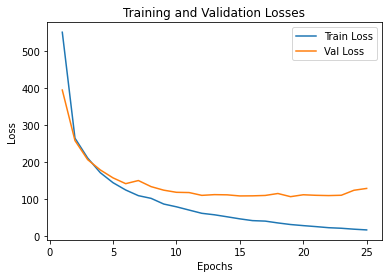

In [15]:
# Plotting training and validation losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Test Loss: 118.6217


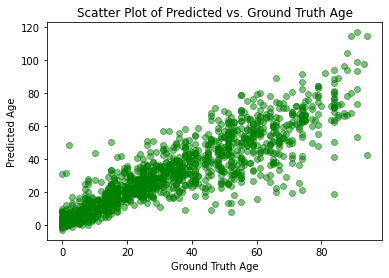

In [16]:
# Experiment 5: Evaluation
# Testing the model
model.eval()
test_loss = 0.0
predictions = []
ground_truths = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item() * images.size(0)
        predictions.extend(outputs.squeeze().cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.sampler)
print(f"Test Loss: {test_loss:.4f}")

# Scatter plot of predicted labels vs. ground truth labels
plt.scatter(ground_truths, predictions, alpha=0.5,color='green')
plt.xlabel('Ground Truth Age')
plt.ylabel('Predicted Age')
plt.title('Scatter Plot of Predicted vs. Ground Truth Age')
plt.show()
